In [1]:
%matplotlib inline

import os
import sys
sys.path.append('../../cnn_design-space/cnnbench/')

import numpy as np
import yaml
from six.moves import cPickle as pickle
import hashlib
import subprocess
import random
from matplotlib import pyplot as plt

from library import GraphLib, Graph
from utils import print_util as pu
import manual_models

In [2]:
config_file_path = '../../cnn_design-space/cnnbench/tests/config_all-ops.yaml'

models_mini = ['vgg11', 'vgg13', 'vgg16', 'vgg19', 'resnet18', 'resnet34', 
               'resnet50', 'resnet101', 'resnet152', 'shufflenet', 'mobilenet', 'googlenet',
               'inception', 'xception']

with open(config_file_path) as config_file:
    try:
        config = yaml.safe_load(config_file)
    except yaml.YAMLError as exc:
        print(exc)

ops = []

for model_name in models_mini:
    model = manual_models.get_manual_graph(config, model_name=model_name)
    for module in model.graph:
        ops.extend(module[1])
        
ops = list(set(ops))

for op in ops:
    assert op in config['base_ops'] + config['dense_ops'] + config['flatten_ops'] \
        + ['dense_classes', 'input', 'output'], \
        f'{op} not in config'
    
print('No ops found outside config')

No ops found outside config


In [4]:
dataset_file_path = '../../cnn_design-space/cnnbench/dataset/dataset_mini.json'
config_file_path = '../../cnn_design-space/cnnbench/tests/config_all-ops.yaml'

graphLib = GraphLib.load_from_dataset(dataset_file_path)

with open(config_file_path) as config_file:
    try:
        config = yaml.safe_load(config_file)
    except yaml.YAMLError as exc:
        print(exc)

models_mini = ['vgg11', 'vgg13', 'vgg16', 'vgg19', 'resnet18', 'resnet34', 
               'resnet50', 'resnet101', 'resnet152', 'shufflenet', 'mobilenet', 'googlenet',
               'inception', 'xception']

# Create a dictionary of hashes for all manual models in dataset_mini
manual_models_hashes = {}
graphLib_hashes = [graph.hash for graph in graphLib.library]
for model_name in models_mini:
    model = manual_models.get_manual_graph(config, model_name=model_name)
    manual_models_hashes[model_name] = model.hash
    
    # Check if this model is in graphLib
    assert model.hash in graphLib_hashes, f'{model_name} is not in graphLib'
    
    print(f'{model_name}: {model.hash}')

vgg11: ad0a60f4a4077a823e03c806612b1739d7dbdcb9955a77b582d18ba9eea0a6b8
vgg13: 6d0862109b4bd4ba489ae97bc9f675734fc2a6a54a210b3a4f391fa01889a982
vgg16: c02c2fde320d179d81af17833c9466bfbfbb1facb42d82e14e9793a9b1ae7979
vgg19: 2bc7895ec217f994d1d1bec034626be9a9f68848c97d62f7e1c493cc8c73330b
resnet18: 1da03cb835aa34f8ccbe0ecf6a025ff9e4f8536e1e1713e9a93c65523b7d885a
resnet34: 0b46c0d8566133b428ec736bea72c8b7eda7e79d477f54c587c1f6a521611998
resnet50: 3abff4667b9e17a30f71ad57a6f7d52d217283984e81a878fceabeb43d299114
resnet101: 4021dbdb0a51fcfab78d87515f07ece1227696d97260b019a76810ba60f5ed03
resnet152: e1aff753f15c8284429fe3e6e9a713d6367e151329576d3701967385b17b48e8
shufflenet: 1a135065feaac7541e71be5767980aafb970e67aa6b938a68235192c823bf3ff
mobilenet: 03c30e238db867874e66e985b6fd494d27661cd17f6ceef332415a5af88b647e
googlenet: 7ea48ef10963fb2a794613dfb2e95e5d6c949217fddb17611cb1861951394232
inception: 7ea48ef10963fb2a794613dfb2e95e5d6c949217fddb17611cb1861951394232
xception: 3227a974145e3074af1f

In [3]:
accel_embeddings_file_path = '../../accelerator_design-space/accelbench/embeddings/embeddings.pkl'

# Initialize Accelerator embeddings
accel_embeddings = pickle.load(open(accel_embeddings_file_path, 'rb'))
accel_embeddings = np.array(accel_embeddings)

print(f'Size of the dataset: {accel_embeddings.shape[0]}')
    
# Check if SPRING is there in accel_embeddings
spring_embedding = np.array([2e0, 16e0, 8e0, 4e0, 8e0, 3e0, 3e0, 1e0, 12e0, 24e0, 4e0, 1e0, 1e0])
spring_present = False

for accel_idx in range(accel_embeddings.shape[0]):
    if (spring_embedding == accel_embeddings[accel_idx, :]).all(): spring_present = True
        
print(f'SPRING present in the dataset: {spring_present}')

Size of the dataset: 228433920
SPRING present in the dataset: True


In [11]:
# Run AccelBench simulations with SPRING and all CNN manual models

models_dir = '/scratch/gpfs/stuli/accelerator_co-design'
cnn_models_dir = os.path.join(models_dir, 'cnnbench_models', config['dataset'])
accel_models_dir = os.path.join(models_dir, 'accelbench_models')

for cnn_model_name, cnn_model_hash in manual_models_hashes.items():
    accel_cnn_str = str(spring_embedding).replace('\n', '') \
        + graphLib.get_graph(model_hash=cnn_model_hash)[0].hash
    accel_hash = hashlib.sha256(accel_cnn_str.encode('utf-8')).hexdigest()
    print(f'accel_hash for SPRING and {cnn_model_name}: {accel_hash}')
    
    args = ['--dataset', config['dataset']]
    args.extend(['--cluster', 'della'])
    args.extend(['--id', 'stuli'])
    args.extend(['--autotune', '0'])
    args.extend(['--cnn_model_hash', cnn_model_hash])
    args.extend(['--cnn_model_dir', os.path.join(cnn_models_dir, cnn_model_hash)])
    args.extend(['--cnn_config_file', config_file_path[3:]])
    args.extend(['--graphlib_file', dataset_file_path[3:]])
    args.extend(['--train_cnn', '0'])
    args.extend(['--accel_hash', accel_hash])
    args.extend(['--accel_emb', '\\"' + str(spring_embedding).replace('\n', '')[1:-1].replace(',', '') + '\\"'])
    args.extend(['--accel_model_file', os.path.join(accel_models_dir, accel_hash) + '.pkl'])
    
    slurm_stdout = subprocess.check_output(
        f'ssh della-gpu "cd accelerator_co-design/boshcode; source ./job_scripts/job_worker.sh {" ".join(args)}"',
        shell=True, text=True, executable="/bin/bash")

    print(f'Job ID: {slurm_stdout.split()[-1]}\n')

accel_hash for SPRING and vgg11: 08a0734b7c753fd8940a5977dfe968cebfe7f5d0a0d6af13837b7c0623bb4b72
Job ID: 39265627

accel_hash for SPRING and vgg13: fa909baf0301c2d43cb80c4935fea98b4a3a13fd97185428fdda12b1d1d0d080
Job ID: 39265628

accel_hash for SPRING and vgg16: 02bd3dacf4b06d0e078d0453d39e501271f350fc01c25f716f92bb2bd2f7f2b5
Job ID: 39265629

accel_hash for SPRING and vgg19: 19bf3b9956047868d1b5546f69595d16b86f440778b28908ab2a61e16849859c
Job ID: 39265630

accel_hash for SPRING and resnet18: d8538572e9c68de1d836917553c56899474ed7b2a678094a1b80536f384ed60b
Job ID: 39265631

accel_hash for SPRING and resnet34: 339a5e3d9d2e22ef9c88b1f39df246598c457684643fd6ce8cdd1db5df4b83ea
Job ID: 39265632

accel_hash for SPRING and resnet50: 27061773536be6deea1e3e9a4e6eb4f19331b87548de395ac0fa1b7fbef571ee
Job ID: 39265633

accel_hash for SPRING and resnet101: 05757f512c3da8cb7188c7faf010668ac94663099b72cb22de1667ed54294ca2
Job ID: 39265634

accel_hash for SPRING and resnet152: 33e627ae0e10b466a3732c

In [10]:
# Run AccelBench simulations with MobileNet with randomly sampled accelerators

models_dir = '/scratch/gpfs/stuli/accelerator_co-design'
cnn_models_dir = os.path.join(models_dir, 'cnnbench_models', config['dataset'])
accel_models_dir = os.path.join(models_dir, 'accelbench_models')

cnn_model_name = 'mobilenet'
cnn_model_hash = manual_models_hashes[cnn_model_name]

# accel_ids = random.sample(range(accel_embeddings.shape[0]), 20)
accel_ids = [3276028, 221900723, 84699796, 168153108, \
             25909481, 129395635, 170308919, 143956161, \
             92764267, 23203293, 35488898, 217046004, \
             199465057, 157480160, 205157577, 87634756, \
             186398986, 197549597, 57256902, 95551424]
print(f'Sampled accelerator indices: {accel_ids}\n')

mobilenet_accel_hashes = []

for accel_id in accel_ids:
    accel_cnn_str = str(accel_embeddings[accel_id, :]).replace('\n', '') \
        + graphLib.get_graph(model_hash=cnn_model_hash)[0].hash
    accel_hash = hashlib.sha256(accel_cnn_str.encode('utf-8')).hexdigest()
    print(f'accel_hash for accel_embedding "{accel_embeddings[accel_id]}" and {cnn_model_name}:\n{accel_hash}')
    
    mobilenet_accel_hashes.append(accel_hash)
    
    args = ['--dataset', config['dataset']]
    args.extend(['--cluster', 'della'])
    args.extend(['--id', 'stuli'])
    args.extend(['--autotune', '0'])
    args.extend(['--cnn_model_hash', cnn_model_hash])
    args.extend(['--cnn_model_dir', os.path.join(cnn_models_dir, cnn_model_hash)])
    args.extend(['--cnn_config_file', config_file_path[3:]])
    args.extend(['--graphlib_file', dataset_file_path[3:]])
    args.extend(['--train_cnn', '0'])
    args.extend(['--accel_hash', accel_hash])
    args.extend(['--accel_emb', '\\"' + str(spring_embedding).replace('\n', '')[1:-1].replace(',', '') + '\\"'])
    args.extend(['--accel_model_file', os.path.join(accel_models_dir, accel_hash) + '.pkl'])
    
    slurm_stdout = subprocess.check_output(
        f'ssh della-gpu "cd accelerator_co-design/boshcode; source ./job_scripts/job_worker.sh {" ".join(args)}"',
        shell=True, text=True, executable="/bin/bash")

    print(f'Job ID: {slurm_stdout.split()[-1]}\n')

Sampled accelerator indices: [3276028, 221900723, 84699796, 168153108, 25909481, 129395635, 170308919, 143956161, 92764267, 23203293, 35488898, 217046004, 199465057, 157480160, 205157577, 87634756, 186398986, 197549597, 57256902, 95551424]

accel_hash for accel_embedding "[ 1  1  1  6  4  1  1  1 14  8  1  2  3]" and mobilenet:
7b8dd7df200e3f6f55e98a477999e9533a45ded15f09360ee6fdced974717e2d
Job ID: 39266430

accel_hash for accel_embedding "[ 4 16  7  6  1  1  1 64 10  8  2  1  1]" and mobilenet:
07a2b32e9eb0a8b9a555f43bc8d9a28f7be80169547a2c7b91a59831f652f880
Job ID: 39266431

accel_hash for accel_embedding "[ 2  1  2  7  2  5  5  1 12 14  2  1  6]" and mobilenet:
0ecf32f36983a4ea3ad47b258a7d37d0a5bbf453401084aa9fb6123e75e8ce57
Job ID: 39266432

accel_hash for accel_embedding "[  4   1   4   3   4   5   5 256   8  24   3   1   3]" and mobilenet:
5a22ce47c71183713d89124ceeca115c3cfe446828efa80912aa2e9b51aa3b58
Job ID: 39266433

accel_hash for accel_embedding "[  1   1   6   4   4   1  

In [5]:
# Get accel_hashes for each case

spring_embedding = np.array([2e0, 16e0, 8e0, 4e0, 8e0, 3e0, 3e0, 1e0, 12e0, 24e0, 4e0, 1e0, 1e0])

spring_accel_hashes = {}

for cnn_model_name, cnn_model_hash in manual_models_hashes.items():
    accel_cnn_str = str(spring_embedding).replace('\n', '') \
        + graphLib.get_graph(model_hash=cnn_model_hash)[0].hash
    accel_hash = hashlib.sha256(accel_cnn_str.encode('utf-8')).hexdigest()
    
    spring_accel_hashes[accel_hash] =  cnn_model_name

accel_ids = [3276028, 221900723, 84699796, 168153108, \
             25909481, 129395635, 170308919, 143956161, \
             92764267, 23203293, 35488898, 217046004, \
             199465057, 157480160, 205157577, 87634756, \
             186398986, 197549597, 57256902, 95551424]

mobilenet_accel_hashes = []

for accel_id in accel_ids:
    accel_cnn_str = str(accel_embeddings[accel_id, :]).replace('\n', '') \
        + graphLib.get_graph(model_hash=manual_models_hashes['mobilenet'])[0].hash
    accel_hash = hashlib.sha256(accel_cnn_str.encode('utf-8')).hexdigest()
    
    mobilenet_accel_hashes.append(accel_hash)

In [6]:
# Get performance metrics for each case

models_dir = '/scratch/gpfs/stuli/accelerator_co-design/models'
cnn_models_dir = os.path.join(models_dir, 'cnnbench_models', config['dataset'])
accel_models_dir = os.path.join(models_dir, 'accelbench_models')

cnn_acc = {'vgg11': 0.91, 'vgg13': 0.92, 'vgg16': 0.92, 'vgg19': 0.93, 'resnet18': 0.90, 'resnet34': 0.91, 
           'resnet50': 0.92, 'resnet101': 0.93, 'resnet150': 0.93, 'shufflenet': 0.9, 'mobilenet': 0.92, 
           'googlenet': 0.93, 'inception': 0.93, 'xception': 0.95}

spring_accel_perf = {}
mobilenet_accel_perf = {}

max_latency, max_area, max_dynamic_energy, max_leakage_energy = 0, 0, 0, 0

for accel_hash in os.listdir(accel_models_dir):
    result = pickle.load(open(os.path.join(accel_models_dir, accel_hash), 'rb'))
    
    if result['latency'] > max_latency: max_latency = result['latency']
    if result['area'] > max_area: max_area = result['area']
    if result['dynamic_energy'] > max_dynamic_energy: max_dynamic_energy = result['dynamic_energy']
    if result['leakage_energy'] > max_leakage_energy: max_leakage_energy = result['leakage_energy']
    
    if accel_hash[:-4] in spring_accel_hashes.keys():
        spring_accel_perf[accel_hash[:-4]] = {'latency': result['latency'], 'area': result['area'],
                                        'dynamic_energy': result['dynamic_energy'], 
                                        'leakage_energy': result['leakage_energy'],
                                        'accuracy': cnn_acc[spring_accel_hashes[accel_hash[:-4]]]}
        
    elif accel_hash[:-4] in mobilenet_accel_hashes:
        mobilenet_accel_perf[accel_hash[:-4]] = {'latency': result['latency'], 'area': result['area'],
                                        'dynamic_energy': result['dynamic_energy'], 
                                        'leakage_energy': result['leakage_energy'],
                                        'accuracy': cnn_acc['mobilenet']}
    
        
print(f'Max latency: {max_latency}')
print(f'Max area: {max_area}')
print(f'Max dynamic energy: {max_dynamic_energy}')
print(f'Max leakage energy: {max_leakage_energy}')

Max latency: 9.522213181428572
Max area: 241.67892060307665
Max dynamic energy: 6323.704377666473
Max leakage energy: 63.70461355265553


In [8]:
# Define performance function

ALPHA, BETA, GAMMA, DELTA, EPSILON = 0.2, 0.1, 0.2, 0.2, 0.3

MAX_LATENCY = 1 # Maximum latency in seconds
MAX_AREA = 1000 # Maximum area in mm^2
MAX_DYNAMIC_ENERGY = 10 # Maximum dynamic energy in Joules
MAX_LEAKAGE_ENERGY = 10 # Maximum leakage energy in Joules

def get_perf(alpha, beta, gamma, delta, epsilon, perf_dict: dict):
    return alpha * (1.0 - perf_dict['latency'] / MAX_LATENCY) + beta * (1.0 - perf_dict['area'] / MAX_AREA) \
            + gamma * (1.0 - perf_dict['dynamic_energy'] / MAX_DYNAMIC_ENERGY) \
            + delta * (1.0 - perf_dict['leakage_energy'] / MAX_LEAKAGE_ENERGY) \
            + epsilon * perf_dict['accuracy']

In [9]:
# Get best CNN-accelerator pair for CNN search

best_cnn_accel_hash = ''
best_cnn_accel_perf_wo_acc = 0

best_spring_accel_hash = ''
best_spring_accel_perf = 0
for accel_hash in spring_accel_perf.keys():
    accel_perf = get_perf(ALPHA, BETA, GAMMA, DELTA, EPSILON, spring_accel_perf[accel_hash])
    accel_perf_wo_acc = get_perf(ALPHA, BETA, GAMMA, DELTA, 0, spring_accel_perf[accel_hash])
    if accel_perf > best_spring_accel_perf:
        best_spring_accel_perf = accel_perf
        best_spring_accel_hash = accel_hash
    if accel_perf_wo_acc > best_cnn_accel_perf_wo_acc:
        best_cnn_accel_perf_wo_acc = accel_perf_wo_acc
        best_cnn_accel_hash = accel_hash
        
best_spring_accel_dict = spring_accel_perf[best_spring_accel_hash]
    
# Get best CNN-accelerator pair for accelerator search
    
best_mobilenet_accel_hash = ''
best_mobilenet_accel_perf = 0
for accel_hash in mobilenet_accel_perf.keys():
    accel_perf = get_perf(ALPHA, BETA, GAMMA, DELTA, EPSILON, mobilenet_accel_perf[accel_hash])
    accel_perf_wo_acc = get_perf(ALPHA, BETA, GAMMA, DELTA, 0, mobilenet_accel_perf[accel_hash])
    if accel_perf > best_mobilenet_accel_perf:
        best_mobilenet_accel_perf = accel_perf
        best_mobilenet_accel_hash = accel_hash
    if accel_perf_wo_acc > best_cnn_accel_perf_wo_acc:
        best_cnn_accel_perf_wo_acc = accel_perf_wo_acc
        best_cnn_accel_hash = accel_hash

best_mobilenet_accel_dict = mobilenet_accel_perf[best_mobilenet_accel_hash]

# Get overal best CNN-accelerator pair for CODE

if best_cnn_accel_hash in spring_accel_perf.keys():
    best_cnn_accel_dict = spring_accel_perf[best_cnn_accel_hash]
else:
    best_cnn_accel_dict = mobilenet_accel_perf[best_cnn_accel_hash]
best_cnn_accel_dict['accuracy'] = 0.95
best_cnn_accel_perf = get_perf(ALPHA, BETA, GAMMA, DELTA, EPSILON, best_cnn_accel_dict)

print(f'Best result from HW-aware NAS: {best_spring_accel_perf}')
print(f'Best result from CNN Acceleration: {best_mobilenet_accel_perf}')
print(f'Best result from HW/SW Co-Design: {best_cnn_accel_perf}')

Best result from HW-aware NAS: 0.9452055646845904
Best result from CNN Acceleration: 0.9349934991558434
Best result from HW/SW Co-Design: 0.9559958480419342


In [10]:
# Create co-design figure

colors = {'latency': '#4292C6', 'area': '#238B45', 'dynamic_energy': '#F1C40F', 'leakage_energy': '#E67E22',
         'accuracy': '#916946'}
metric_labels = {'latency': '1 - Latency', 'area': '1 - Area', 'dynamic_energy': '1 - Dyn. Energy', 
                'leakage_energy': '1 - Leak. Energy', 'accuracy': 'Accuracy'} 
# metric_labels = {'latency': 'Latency', 'area': 'Area', 'dynamic_energy': 'Dyn. Energy', 
#                 'leakage_energy': 'Leak. Energy', 'accuracy': 'Accuracy'} 
metric_norm = {'latency': MAX_LATENCY, 'area': MAX_AREA, 'dynamic_energy': MAX_DYNAMIC_ENERGY, 
              'leakage_energy': MAX_LEAKAGE_ENERGY, 'accuracy': 1}

exp_types = {'CNN Acceleration': best_mobilenet_accel_dict, 
             'HW-aware NAS': best_spring_accel_dict, 
             'HW/SW Co-Design': best_cnn_accel_dict}

x = np.arange(len(exp_types))
width = 0.15

fig, ax = plt.subplots(figsize=(6.4, 4))

ax.bar(x, [0.96*best_mobilenet_accel_perf, 0.96*best_spring_accel_perf, 1.005*best_cnn_accel_perf], 5.05*width,
      label='Performance', color='white', edgecolor='black', linestyle='--')

count = 0
for metric in metric_labels.keys():
    if metric in ['latency', 'area', 'dynamic_energy', 'leakage_energy']:
        values = [(1.0 - exp_types[exp][metric]/metric_norm[metric]) for exp in exp_types.keys()]
        values = [0.95*values[0], 0.95*values[1], values[2]]
    else:
        values = [exp_types[exp][metric]/metric_norm[metric] for exp in exp_types.keys()]
        values = [0.98*values[0], 0.97*values[1], values[2]]
    ax.bar(x - 2*width + width*count, values, 
         width, label=metric_labels[metric], color=colors[metric])
    count += 1
    
# count = 0
# for metric in metric_labels.keys():
#     if metric in ['latency', 'area', 'dynamic_energy', 'leakage_energy']:
#         values = [(1.0 - exp_types[exp][metric]/metric_norm[metric]) for exp in exp_types.keys()]
#         values = [0.95*values[0], 0.95*values[1], values[2]]
#         ax.bar(x - 1.5*width + width*count, [1 - value for value in values], 
#              width, label=metric_labels[metric], color=colors[metric])
#     else:
#         values = [exp_types[exp][metric]/metric_norm[metric] for exp in exp_types.keys()]
#         values = [0.98*values[0], 0.97*values[1], values[2]]
#         print(values)
#     count += 1
    

ax.set_ylabel('Normalized Performance Metrics', fontsize=12)
ax.set_xticks(x)
ax.set_xticklabels(exp_types.keys(), fontsize=12)

handles, labels = plt.gca().get_legend_handles_labels()
order = [1, 2, 3, 4, 5, 0]
plt.legend([handles[idx] for idx in order],[labels[idx] for idx in order], loc='lower right')
# plt.legend(loc='upper right')

ax.set_ylim([0.6, 1])
fig.tight_layout()
plt.grid(axis = 'y', linestyle='--')
# plt.savefig(f'code_vs_one-sided_approaches.pdf', bbox_inches = 'tight')
plt.show()

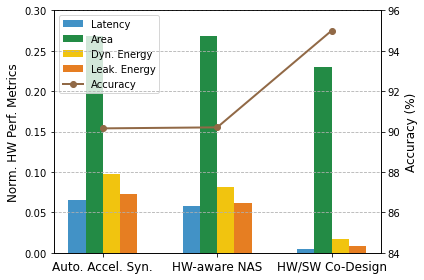

In [15]:
# Create preliminary figure
%matplotlib inline

colors = {'latency': '#4292C6', 'area': '#238B45', 'dynamic_energy': '#F1C40F', 'leakage_energy': '#E67E22',
         'accuracy': '#916946'}
# metric_labels = {'latency': '1 - Latency', 'area': '1 - Area', 'dynamic_energy': '1 - Dyn. Energy', 
#                 'leakage_energy': '1 - Leak. Energy', 'accuracy': 'Accuracy'} 
metric_labels = {'latency': 'Latency', 'area': 'Area', 'dynamic_energy': 'Dyn. Energy', 
                'leakage_energy': 'Leak. Energy', 'accuracy': 'Accuracy'} 
metric_norm = {'latency': MAX_LATENCY, 'area': MAX_AREA, 'dynamic_energy': MAX_DYNAMIC_ENERGY, 
              'leakage_energy': MAX_LEAKAGE_ENERGY, 'accuracy': 1}

exp_types = {'Auto. Accel. Syn.': best_mobilenet_accel_dict, 
             'HW-aware NAS': best_spring_accel_dict, 
             'HW/SW Co-Design': best_cnn_accel_dict}

x = np.arange(len(exp_types))
width = 0.15

fig, ax = plt.subplots()
ax2 = ax.twinx()

# ax.bar(x, [0.96*best_mobilenet_accel_perf, 0.96*best_spring_accel_perf, 1.005*best_cnn_accel_perf], 5.05*width,
#       label='Performance', color='white', edgecolor='black', linestyle='--')

# count = 0
# for metric in metric_labels.keys():
#     if metric in ['latency', 'area', 'dynamic_energy', 'leakage_energy']:
#         values = [(1.0 - exp_types[exp][metric]/metric_norm[metric]) for exp in exp_types.keys()]
#         values = [0.95*values[0], 0.95*values[1], values[2]]
#     else:
#         values = [exp_types[exp][metric]/metric_norm[metric] for exp in exp_types.keys()]
#         values = [0.98*values[0], 0.97*values[1], values[2]]
#     ax.bar(x - 2*width + width*count, values, 
#          width, label=metric_labels[metric], color=colors[metric])
#     count += 1
    
count = 0
for metric in metric_labels.keys():
    if metric in ['latency', 'area', 'dynamic_energy', 'leakage_energy']:
        values = [(1.0 - exp_types[exp][metric]/metric_norm[metric]) for exp in exp_types.keys()]
        values = [0.95*values[0], 0.95*values[1], values[2]]
        ax.bar(x - 1.5*width + width*count, [1 - value for value in values], 
             width, label=metric_labels[metric], color=colors[metric])
    else:
        values = [exp_types[exp][metric]/metric_norm[metric] for exp in exp_types.keys()]
        values = [0.98*values[0], 0.97*values[1], values[2]]
        values = [100*val for val in values]
        ax2.plot(values, 'o-', label=metric_labels[metric], color=colors[metric], linewidth=2)
    count += 1
    

ax.set_ylabel('Norm. HW Perf. Metrics', fontsize=12)
ax.set_xticks(x)
ax.set_xticklabels(exp_types.keys(), fontsize=12)

ax2.set_ylabel('Accuracy (%)', fontsize=12)

handles, labels = plt.gca().get_legend_handles_labels()
# order = [1, 2, 3, 4, 5, 0]
# plt.legend([handles[idx] for idx in order],[labels[idx] for idx in order], loc='lower right')
lines, labels = ax.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax.legend(lines + lines2, labels + labels2, loc='upper left')

# ax.set_ylim([0.6, 1])
ax.set_ylim([0, 0.3])
ax2.set_ylim([84, 96])
fig.tight_layout()
plt.grid(axis = 'y', linestyle='--')
plt.savefig(f'../figures/code_vs_one-sided_approaches_reversed.pdf', bbox_inches = 'tight')
plt.show()